#**Checking Overfitting - Underfitting and Searching the best hyperparameters for a Neuronal Network**

##**Made by**

*   Luis Miguel Ossa - A00369982
*   Keren López Córdoba - A00368902

##**About dataset**
There are 269 images with the faces and bodies of Homer and Bart, the images already have the names, which facilitates the processing and training of the neural network.

![](https://storage.googleapis.com/kaggle-datasets-images/1761725/2876405/e1c4a37080cd7d46e92e2b0d61627a44/dataset-cover.jpg?t=2021-12-02-02-17-49)

# **Checking Overfitting and Underfitting**

Based on the code of the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

##**Import libraries**

In [1]:
!pip install scikeras

In [2]:
import keras
keras.__version__

'2.15.0'

In [3]:
# Importa la funcionalidad de carga de archivos desde Google Colab.
from google.colab import files

# Importa módulos para operaciones y manipulación de datos.
from pathlib import Path  # Para manipulación de rutas de archivos y directorios.
import cv2  # Para procesamiento de imágenes.
import numpy as np  # Para operaciones numéricas.
import pandas as pd  # Para manipulación de datos tabulares.

# Importa la función para dividir datos en conjuntos de entrenamiento y prueba.
from sklearn.model_selection import train_test_split

# Importa la biblioteca para visualización de datos.
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten, Activation
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow as tf

In [4]:
# Monta Google Drive en Colab.
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##**Data processing**

In [5]:
# Nuevo tamaño para cada una de las imágenes.
width, height = 128, 128

In [6]:
# Inicializa las listas 'classification' y 'images'.
# 'imagesPath' apunta al directorio de imágenes en Google Drive.classification = []
images = []
classification = []
imagesPath = Path('/content/drive/MyDrive/Colab Notebooks/test_datasets/homer_bart_1')

# Se itera sobre los archivos en 'imagesPath' para clasificarlos (1 para 'homer', 0 para 'bart').
for pathImage in imagesPath.iterdir():
    if pathImage.name.startswith('h'):
        classification.append(1)
    else:
        classification.append(0)

    # Lee, redimensiona y agrega las imágenes a la lista 'images'.
    image = cv2.imread(str(pathImage))
    image = cv2.resize(image, (width, height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)


In [7]:
#Convertir las listas de clasificación e imagenes en arreglos de numpy.
classification_array = np.array(classification)
images_array = np.array(images)

In [8]:
#Escalar el arreglo de imágenes para que todos sus valores queden entre 0 y 1.
images_array = images_array / 255.0

In [9]:
images_array[0].shape

(128, 128, 3)

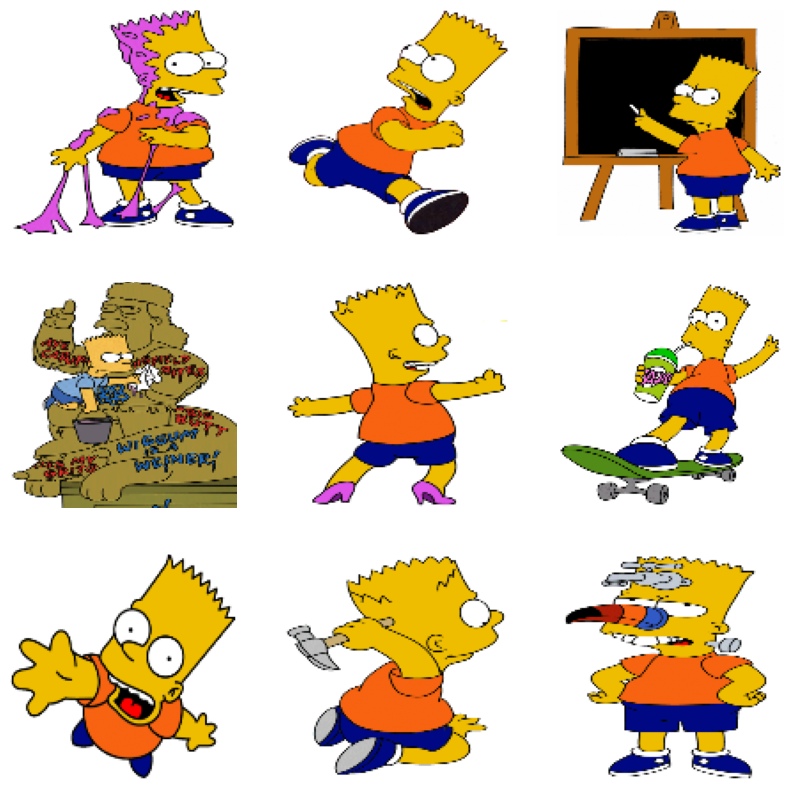

In [10]:
# Crea un gráfico de 3x3 para visualizar las primeras 9 imágenes en 'images_array'.
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images_array[i])
    plt.axis(False)

##**Data split (sets of 80/20)**

In [11]:
# Divide los conjuntos de datos en entrenamiento y prueba utilizando 'train_test_split'.
train_data, test_data, train_labels, test_labels = train_test_split(images_array, classification_array, test_size=0.2, random_state=42)

In [12]:
train_data.shape

(215, 128, 128, 3)

In [13]:
test_data.shape

(54, 128, 128, 3)

In [14]:
train_labels.shape

(215,)

In [15]:
test_labels.shape

(54,)

In [16]:
type(train_data)

numpy.ndarray

##**Vectorized train and test data**

In [17]:
numero_fotos = 128 * 128 * 3 # define el total de fotos utilizadas del dataset

In [18]:
import numpy as np

'''
Function that takes the array of images and reshapes them into a 2D array, where each row represents a flattened version of an image.
'''

def vectorize_images(images):
    num_images = images.shape[0]
    flattened_size = np.prod(images.shape[1:])  # Calcula el tamaño total de cada imagen
    return images.reshape(num_images, flattened_size)

# Vectorización de los datos de imágenes
x_train = vectorize_images(train_data)
x_test = vectorize_images(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

print(x_train.shape)  # Salida: (215, 49152) (215 imágenes, cada una de 128x128x3 píxeles)
print(x_test.shape)   # Salida: (50, 49152) (50 imágenes, cada una de 128x128x3 píxeles)


(215, 49152)
(54, 49152)


In [19]:
#Converts a class vector (integers) to binary class matrix:
#from keras.utils import to_categorical
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

In [20]:
print(y_train.shape)
print(y_test.shape)

(215,)
(54,)


## **Fighting overfitting**

### **Reducing the network's size**


The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is
determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is
often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any
generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the
MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying
new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge
is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in
order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets
-- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have
enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be
found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You
will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the
right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the
validation loss.

Let's try this on our Homer and Bart classification network. We are going to proof with 3 models in total: our original model (2 layers with 16 nodes + 1 layer with 2 nodes and sigmoid function), a smaller model (2 layers with 4 nodes + 1 layer with 2 nodes and sigmoid function), and a bigger model (2 layers with 128 nodes + 1 layer with 2 nodes and sigmoid function) to see which one performs better.

###**Following the machine learning recipe**

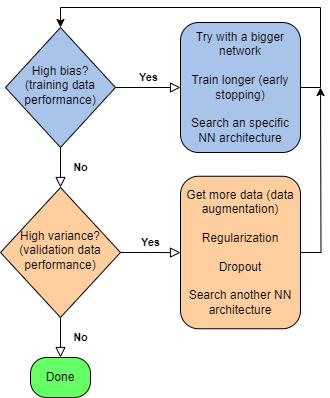


##**Step #1: Analyzing training loss to check bias**

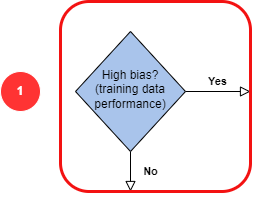

###**Original model - 16 nodes**

In [21]:
original_model = Sequential()
original_model.add(Dense(16, activation='relu', input_shape=(numero_fotos,)))
original_model.add(Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [22]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=128,
                                   validation_data=(x_test, y_test))

Epoch 1/20
2/2 [==============================] - 1s 306ms/step - loss: 16.0790 - acc: 0.6000 - val_loss: 53.7679 - val_acc: 0.4259
Epoch 2/20
2/2 [==============================] - 0s 98ms/step - loss: 35.1363 - acc: 0.4279 - val_loss: 0.7339 - val_acc: 0.4259
Epoch 3/20
2/2 [==============================] - 0s 134ms/step - loss: 0.6936 - acc: 0.5349 - val_loss: 0.6928 - val_acc: 0.5741
Epoch 4/20
2/2 [==============================] - 0s 111ms/step - loss: 0.6927 - acc: 0.6000 - val_loss: 0.6927 - val_acc: 0.5741
Epoch 5/20
2/2 [==============================] - 0s 93ms/step - loss: 0.6926 - acc: 0.6000 - val_loss: 0.6927 - val_acc: 0.5741
Epoch 6/20
2/2 [==============================] - 0s 79ms/step - loss: 0.6925 - acc: 0.6000 - val_loss: 0.6926 - val_acc: 0.5741
Epoch 7/20
2/2 [==============================] - 0s 89ms/step - loss: 0.6924 - acc: 0.6000 - val_loss: 0.6925 - val_acc: 0.5741
Epoch 8/20
2/2 [==============================] - 0s 146ms/step - loss: 0.6922 - acc: 0.600

In [23]:
epochs = range(1, 21)
original_train_loss = original_hist.history['loss']

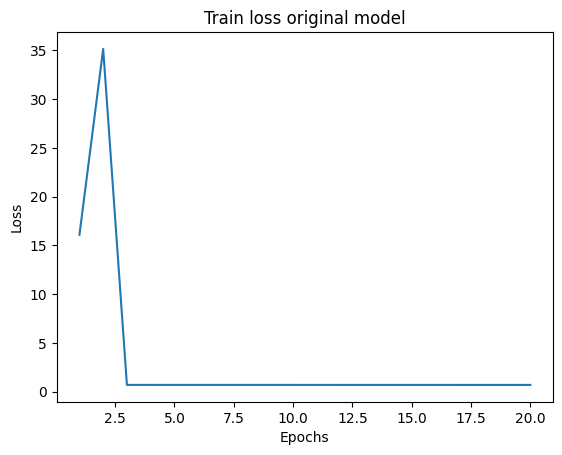

In [24]:
plt.plot(epochs, original_train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss original model')

plt.show()

Now let's try with a smaller network:

###**Smaller model - 4 nodes**

In [25]:
smaller_model = Sequential()
smaller_model.add(Dense(4, activation='relu', input_shape=(numero_fotos,)))
smaller_model.add(Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

In [26]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=128,
                                       validation_data=(x_test, y_test))

Epoch 1/20
2/2 [==============================] - 1s 299ms/step - loss: 7.9370 - acc: 0.5628 - val_loss: 0.6931 - val_acc: 0.5741
Epoch 2/20
2/2 [==============================] - 0s 74ms/step - loss: 0.6931 - acc: 0.6000 - val_loss: 0.6930 - val_acc: 0.5741
Epoch 3/20
2/2 [==============================] - 0s 85ms/step - loss: 0.6929 - acc: 0.6000 - val_loss: 0.6929 - val_acc: 0.5741
Epoch 4/20
2/2 [==============================] - 0s 91ms/step - loss: 0.6928 - acc: 0.6000 - val_loss: 0.6928 - val_acc: 0.5741
Epoch 5/20
2/2 [==============================] - 0s 88ms/step - loss: 0.6926 - acc: 0.6000 - val_loss: 0.6926 - val_acc: 0.5741
Epoch 6/20
2/2 [==============================] - 0s 80ms/step - loss: 0.6924 - acc: 0.6000 - val_loss: 0.6925 - val_acc: 0.5741
Epoch 7/20
2/2 [==============================] - 0s 72ms/step - loss: 0.6922 - acc: 0.6000 - val_loss: 0.6924 - val_acc: 0.5741
Epoch 8/20
2/2 [==============================] - 0s 83ms/step - loss: 0.6921 - acc: 0.6000 - va

In [27]:
smaller_train_loss = smaller_model_hist.history['loss']

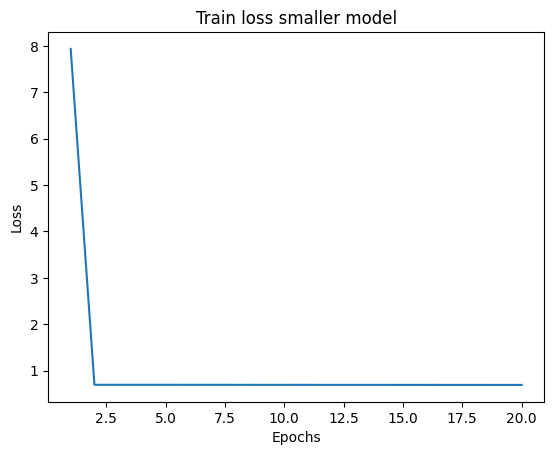

In [28]:
plt.plot(epochs, smaller_train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss smaller model')

plt.show()

Now, let's try with a bigger model:

###**Bigger model - 128 nodes**

In [29]:
bigger_model = Sequential()
bigger_model.add(Dense(128, activation='relu', input_shape=(numero_fotos,)))
bigger_model.add(Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [30]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=128,
                                     validation_data=(x_test, y_test))

Epoch 1/20
2/2 [==============================] - 2s 554ms/step - loss: 48.6835 - acc: 0.6000 - val_loss: 73.3918 - val_acc: 0.4259
Epoch 2/20
2/2 [==============================] - 0s 149ms/step - loss: 53.3967 - acc: 0.4000 - val_loss: 4.1110 - val_acc: 0.4259
Epoch 3/20
2/2 [==============================] - 0s 194ms/step - loss: 2.9982 - acc: 0.4186 - val_loss: 0.6921 - val_acc: 0.5741
Epoch 4/20
2/2 [==============================] - 0s 201ms/step - loss: 0.6922 - acc: 0.6093 - val_loss: 0.8610 - val_acc: 0.4259
Epoch 5/20
2/2 [==============================] - 0s 218ms/step - loss: 0.7958 - acc: 0.5023 - val_loss: 0.6919 - val_acc: 0.5741
Epoch 6/20
2/2 [==============================] - 0s 232ms/step - loss: 0.6920 - acc: 0.6047 - val_loss: 0.6919 - val_acc: 0.5741
Epoch 7/20
2/2 [==============================] - 0s 170ms/step - loss: 0.6918 - acc: 0.6047 - val_loss: 0.6918 - val_acc: 0.5741
Epoch 8/20
2/2 [==============================] - 0s 200ms/step - loss: 0.6916 - acc: 0

In [31]:
bigger_train_loss = bigger_model_hist.history['loss']

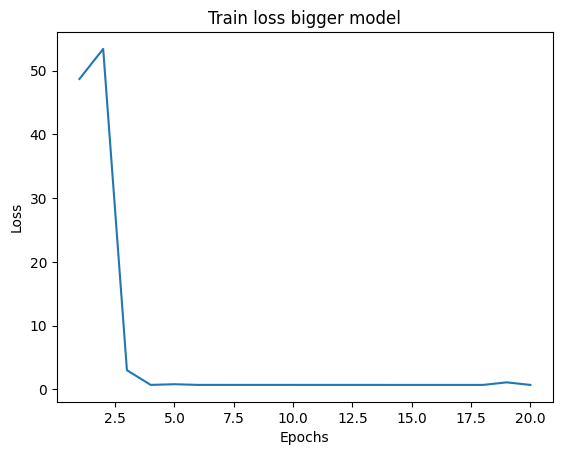

In [32]:
plt.plot(epochs, bigger_train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss bigger model')

plt.show()

Let's plot the training losses of the 3 models to make conclusions:

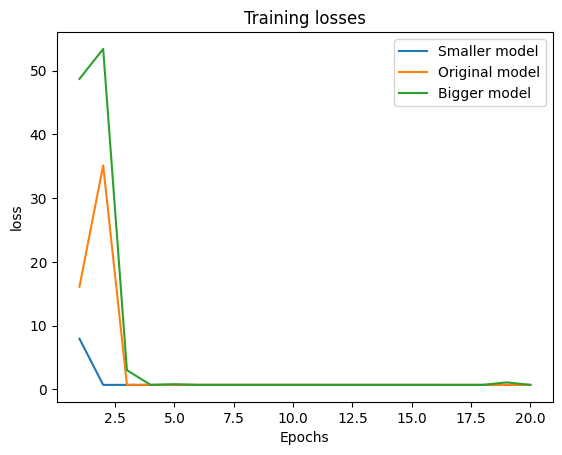

In [33]:
bigger_model_loss = bigger_model_hist.history['loss']

plt.title("Training losses")
plt.plot(epochs, smaller_train_loss, label='Smaller model')
plt.plot(epochs, original_train_loss, label='Original model')
plt.plot(epochs, bigger_train_loss, label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

Training loss should decreases with the number of training iterations, so according to the graphic, we can say that...

*   The original model gets its training loss near zero very quickly (presents low bias), but we have to be careful, it can be more susceptible to overfitting (resulting in a large difference between the training and validation loss), so we will see how it behaves later in the next section.
*   The smaller model loss decreases its training loss as the epochs go by, but unlike the original model, it does it very slowly.
*   The bigger network has a good behavior, but compares to the other ones it's very variable throught the number of epochs.

We can say that the original model is the best when it comes to the rapid decrease of the training dataset loss function. Moreover, there isn't high bias, so let's continue to the next step.

##**Step #2: Analyzing validation loss to check variance**
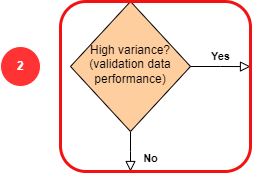

In [34]:
original_val_loss = original_hist.history['val_loss']
smaller_val_loss = smaller_model_hist.history['val_loss']
bigger_val_loss = bigger_model_hist.history['val_loss']

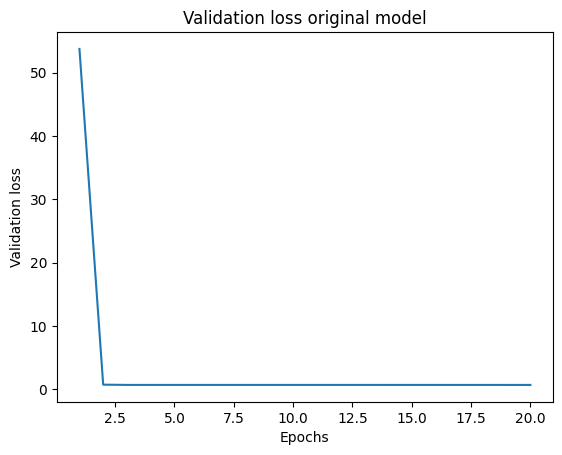

In [35]:
plt.plot(epochs, original_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.title('Validation loss original model')

plt.show()

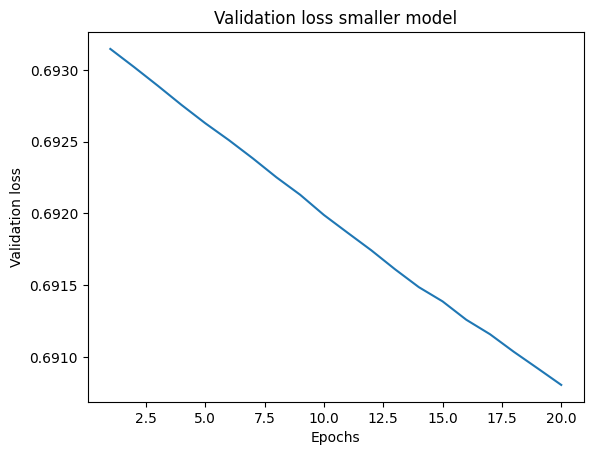

In [36]:
plt.plot(epochs, smaller_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.title('Validation loss smaller model')

plt.show()

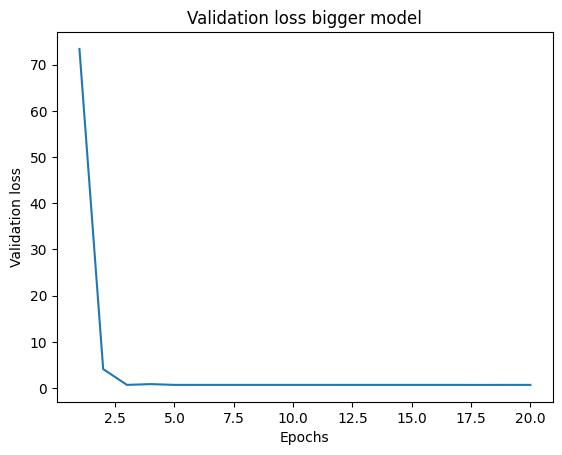

In [37]:
plt.plot(epochs, bigger_val_loss)
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.title('Validation loss bigger model')

plt.show()

Let's plot the validation losses of the 3 models to make conclusions:

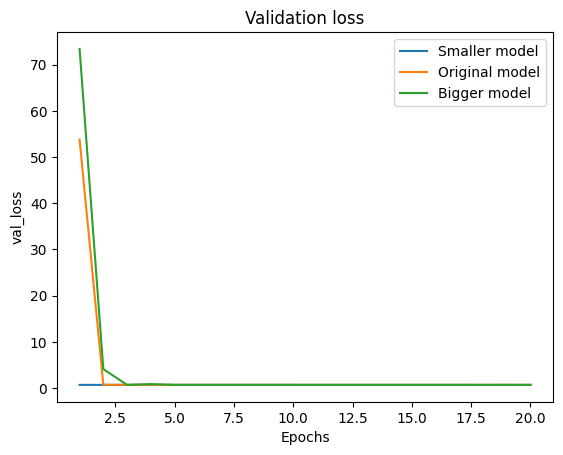

In [38]:
plt.title("Validation loss")
plt.plot(epochs, smaller_val_loss, label='Smaller model')
plt.plot(epochs, original_val_loss, label='Original model')
plt.plot(epochs, bigger_val_loss, label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('val_loss')
plt.legend()

plt.show()

Validation loss also should decreases with the number of training iterations, so according to the graphic, we can say that...

*   The original model gets its validation loss near zero very quickly (presents low variance) and there isn't overfitting because it doesn't exist a significant difference between the training and validation loss.
*   The smaller model loss decreases its validation loss as the epochs go by, but unlike the original model, it does it very slowly.
*   The bigger network has a good behavior, but compares to the other ones it's very variable throught the number of epochs.

We can say that the original model is the best when it comes to the rapid decrease of the validation dataset loss function, and that there isn't high variance.

Now let's plot training and validation losses of all models to see diferences:

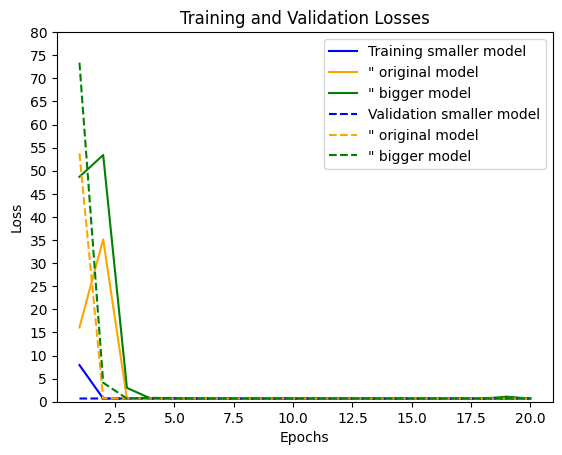

In [39]:
import matplotlib.pyplot as plt

# Define los colores para cada modelo
colors = {'Smaller model': 'blue', 'Original model': 'orange', 'Bigger model': 'green'}

# Gráfica de Training losses
plt.title("Training and Validation Losses")
plt.plot(epochs, smaller_train_loss, label='Training smaller model', color=colors['Smaller model'])
plt.plot(epochs, original_train_loss, label='" original model', color=colors['Original model'])
plt.plot(epochs, bigger_train_loss, label='" bigger model', color=colors['Bigger model'])

# Gráfica de Validation loss
plt.plot(epochs, smaller_val_loss, linestyle='--', label='Validation smaller model', color=colors['Smaller model'])
plt.plot(epochs, original_val_loss, linestyle='--', label='" original model', color=colors['Original model'])
plt.plot(epochs, bigger_val_loss, linestyle='--', label='" bigger model', color=colors['Bigger model'])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.ylim(0, 80)
plt.yticks(np.arange(0, 81, 5))  # Marcadores de 0 a 80 en incrementos de 5

plt.show()

##**Dropout**

it seems that the original model without dropout performed well in terms of training and validation loss. Dropout is a regularization technique commonly used to prevent overfitting in neural networks by randomly dropping out a proportion of neurons during training. However, if the original model already achieves stable and satisfactory performance without exhibiting overfitting or underfitting issues, there might not be a need to introduce dropout.

In this case, since the models achieved stable training and validation loss without dropout, it suggests that the original model architecture was sufficiently robust and well-regularized on its own. Therefore, there was no need to incorporate dropout regularization, as it might have introduced unnecessary complexity without significant improvement in performance.

##**Conclusion**

We're done!! In conclusion, the training and validation loss in all models decrease and stabilize at a specific point, so we don't have problems related to high bias, high variance or even overfitting and underfitting. Finally, it's the original model who has the best loss function behavior with both datasets (train and validation).

#**Using GridSearchCV to find the best hyperparameters**


Based on [Machine Learning Mastery](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/).

In [40]:
best_scores = {}

##**Training Dataset**

###**Searching the best number of epochs and batch_size**

In [41]:
# Function to create model, required for KerasClassifier
def create_model():
  original_model = Sequential()
  original_model.add(Dense(16, activation='relu', input_shape=(numero_fotos,)))
  original_model.add(Dense(1, activation='sigmoid'))
  original_model.compile(optimizer='rmsprop',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
  return original_model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
model = KerasClassifier(model=create_model, verbose=1)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)
grid_result = grid.fit(x_train, y_train)

best_scores.update({
    'batch_size': grid_result.best_params_['batch_size'],
    'epochs': grid_result.best_params_['epochs']
})

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/10
22/22 [==============================] - 1s 9ms/step - loss: 4.7838 - accuracy: 0.5395
Epoch 2/10
22/22 [==============================] - 0s 9ms/step - loss: 0.6915 - accuracy: 0.6000
Epoch 3/10
22/22 [==============================] - 0s 9ms/step - loss: 1.0521 - accuracy: 0.6000
Epoch 4/10
22/22 [==============================] - 0s 8ms/step - loss: 0.6880 - accuracy: 0.6000
Epoch 5/10
22/22 [==============================] - 0s 9ms/step - loss: 0.7197 - accuracy: 0.6000
Epoch 6/10
22/22 [==============================] - 0s 11ms/step - loss: 0.6883 - accuracy: 0.6000
Epoch 7/10
22/22 [==============================] - 0s 12ms/step - loss: 0.6873 - accuracy: 0.6000
Epoch 8/10
22/22 [==============================] - 0s 11ms/step - loss: 0.6864 - accuracy: 0.6000
Epoch 9/10
22/22 [==============================] - 0s 11ms/step - loss: 0.6856 - accuracy: 0.6000
Epoch 10/10
22/22 [==============================] - 0s 9ms/step - loss: 0.6849 - accuracy: 0.6000
Best: 0.646322 

###**Searching the best optimizer**

In [47]:
# Function to create model, required for KerasClassifier
def create_model(optimizer):
  original_model = Sequential()
  original_model.add(Dense(16, activation='relu', input_shape=(numero_fotos,)))
  original_model.add(Dense(1, activation='sigmoid'))

  # Compile model
  original_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # fix random seed for reproducibility
  seed = 7
  tf.random.set_seed(seed)

  return original_model

# create model
model = KerasClassifier(build_fn=create_model, epochs=best_scores['epochs'], batch_size=best_scores['batch_size'], verbose=1)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(model__optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)
grid_result = grid.fit(x_train, y_train)

best_scores.update({'model__optimizer': grid_result.best_params_['model__optimizer']})

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 7 candidates, totalling 21 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
22/22 [==============================] - 1s 20ms/step - loss: 0.6940 - accuracy: 0.5488
Epoch 2/10
22/22 [==============================] - 0s 16ms/step - loss: 0.6794 - accuracy: 0.5767
Epoch 3/10
22/22 [==============================] - 0s 14ms/step - loss: 0.6631 - accuracy: 0.5488
Epoch 4/10
22/22 [==============================] - 0s 16ms/step - loss: 0.6641 - accuracy: 0.6140
Epoch 5/10
22/22 [==============================] - 0s 15ms/step - loss: 0.6511 - accuracy: 0.6326
Epoch 6/10
22/22 [==============================] - 0s 18ms/step - loss: 0.6434 - accuracy: 0.6279
Epoch 7/10
22/22 [==============================] - 0s 16ms/step - loss: 0.6334 - accuracy: 0.6372
Epoch 8/10
22/22 [==============================] - 0s 16ms/step - loss: 0.6275 - accuracy: 0.6419
Epoch 9/10
22/22 [==============================] - 0s 16ms/step - loss: 0.6214 - accuracy: 0.6884
Epoch 10/10
22/22 [==============================] - 0s 16ms/step - loss: 0.6133 - accuracy: 0.6744
Best: 0.6

###**Searching the best Learning Rate and Momentum**

In [48]:
# Function to create model, required for KerasClassifier
def create_model():
  # create model
  original_model = Sequential()
  original_model.add(Dense(16, activation='relu', input_shape=(numero_fotos,)))
  original_model.add(Dense(1, activation='sigmoid'))
  original_model.compile(loss='binary_crossentropy', metrics=['accuracy'])
  return original_model
# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
model = KerasClassifier(
    model=create_model,
    optimizer=best_scores['model__optimizer'],
    epochs=best_scores['epochs'],
    batch_size=best_scores['batch_size'],
    verbose=0
)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, error_score='raise')
grid_result = grid.fit(x_train, y_train)

best_scores.update({
    'optimizer__learning_rate': grid_result.best_params_['optimizer__learning_rate'],
    'optimizer__momentum': grid_result.best_params_['optimizer__momentum']
})


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best: 0.637520 using {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.600026 (0.003965) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.0}
0.637520 (0.047508) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.2}
0.600026 (0.003965) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.4}
0.600026 (0.003965) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.6}
0.600026 (0.003965) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.8}
0.595396 (0.009195) with: {'optimizer__learning_rate': 0.001, 'optimizer__momentum': 0.9}
0.618610 (0.017028) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.0}
0.600026 (0.003965) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.2}
0.600026 (0.003965) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.4}
0.600026 (0.003965) with: {'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.6}
0.600026 (0.003965)

###**Tunning the network weight initialization**

In [49]:
from keras.optimizers import Adadelta

# Function to create model, required for KerasClassifier
def create_model(init_mode):
  original_model = Sequential()
  original_model.add(Dense(16, activation='relu', kernel_initializer=init_mode, input_shape=(numero_fotos,)))
  original_model.add(Dense(1, activation='sigmoid', kernel_initializer=init_mode))

  # Compile model
  opt = Adadelta(learning_rate=best_scores['optimizer__learning_rate'], rho=best_scores['optimizer__momentum'])

  original_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return original_model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

# create model
model = KerasClassifier(
    model=create_model,
    epochs=best_scores['epochs'],
    batch_size=best_scores['batch_size'],
    verbose=1
)

# define the grid search parameters
init_mode_1 = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(model__init_mode=init_mode_1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

best_scores.update({'init_mode': grid_result.best_params_['model__init_mode']})

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Epoch 1/10
22/22 [==============================] - 1s 15ms/step - loss: 0.7364 - accuracy: 0.4372
Epoch 2/10
22/22 [==============================] - 0s 15ms/step - loss: 0.7197 - accuracy: 0.5023
Epoch 3/10
22/22 [==============================] - 0s 18ms/step - loss: 0.7093 - accuracy: 0.5023
Epoch 4/10
22/22 [==============================] - 0s 16ms/step - loss: 0.7071 - accuracy: 0.5395
Epoch 5/10
22/22 [==============================] - 0s 16ms/step - loss: 0.7011 - accuracy: 0.5349
Epoch 6/10
22/22 [==============================] - 0s 17ms/step - loss: 0.6969 - accuracy: 0.5302
Epoch 7/10
22/22 [==============================] - 0s 12ms/step - loss: 0.6904 - accuracy: 0.5442
Epoch 8/10
22/22 [==============================] - 0s 12ms/step - loss: 0.6875 - accuracy: 0.5488
Epoch 9/10
22/22 [==============================] - 0s 13ms/step - loss: 0.6838 - accuracy: 0.5442
Epoch 10/10
22/22 [==============================] - 0s 14ms/step - loss: 0.6797 - accuracy: 0.5721
Best: 0.6

###**Tunning the Neuron Activation Function**

In [51]:
# Function to create model, required for KerasClassifier
def create_model(activation_1):
  original_model = Sequential()
  original_model.add(Dense(16, activation=activation_1, kernel_initializer=best_scores['init_mode'], input_shape=(numero_fotos,)))
  original_model.add(Dense(1, activation='sigmoid', kernel_initializer=best_scores['init_mode']))

  # Compile model
  opt = Adadelta(learning_rate=best_scores['optimizer__learning_rate'], rho=best_scores['optimizer__momentum'])
  original_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  # fix random seed for reproducibility
  seed = 7
  tf.random.set_seed(seed)

  return original_model

# create model
model = KerasClassifier(
    model=create_model,
    epochs=best_scores['epochs'],
    batch_size=best_scores['batch_size'],
    verbose=0
)
# define the grid search parameters
activation_1 = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

param_grid = dict(model__activation_1=activation_1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

best_scores.update({'model__activation_1': grid_result.best_params_['model__activation_1']})

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.623174 using {'model__activation_1': 'relu'}
0.609416 (0.017244) with: {'model__activation_1': 'softmax'}
0.613850 (0.027624) with: {'model__activation_1': 'softplus'}
0.572183 (0.031485) with: {'model__activation_1': 'softsign'}
0.623174 (0.030945) with: {'model__activation_1': 'relu'}
0.609220 (0.021106) with: {'model__activation_1': 'tanh'}
0.600026 (0.003965) with: {'model__activation_1': 'sigmoid'}
0.595331 (0.002674) with: {'model__activation_1': 'hard_sigmoid'}
0.562989 (0.037732) with: {'model__activation_1': 'linear'}


###**Tunning Dropout Regularization**

In [53]:
from keras.constraints import MaxNorm

def create_model(dropout_rate_1, weight_constraint_1):
  original_model = Sequential()
  original_model.add(Dense(16, activation=best_scores['model__activation_1'], kernel_initializer=best_scores['init_mode'], kernel_constraint=MaxNorm(weight_constraint_1), input_shape=(numero_fotos,)))
  original_model.add(Dropout(dropout_rate_1))
  original_model.add(Dense(1, activation='sigmoid', kernel_initializer=best_scores['init_mode']))

  # Compile model
  opt = Adadelta(learning_rate=best_scores['optimizer__learning_rate'], rho=best_scores['optimizer__momentum'])
  original_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  # fix random seed for reproducibility
  seed = 7
  tf.random.set_seed(seed)

  return original_model

# create model
model = KerasClassifier(
    model=create_model,
    epochs=best_scores['epochs'],
    batch_size=best_scores['batch_size'],
    verbose=1
)

# define the grid search parameters
weight_constraint_1 = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate_1 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

param_grid = dict(model__dropout_rate_1=dropout_rate_1, model__weight_constraint_1=weight_constraint_1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)
grid_result = grid.fit(x_train, y_train)

best_scores.update({
    'model__dropout_rate_1' : grid_result.best_params_['model__dropout_rate_1'],
    'model__weight_constraint_1' : grid_result.best_params_['model__weight_constraint_1']
})

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Epoch 1/10
22/22 [==============================] - 2s 15ms/step - loss: 0.7347 - accuracy: 0.5907
Epoch 2/10
22/22 [==============================] - 0s 14ms/step - loss: 0.6986 - accuracy: 0.5860
Epoch 3/10
22/22 [==============================] - 0s 14ms/step - loss: 0.6654 - accuracy: 0.6279
Epoch 4/10
22/22 [==============================] - 0s 14ms/step - loss: 0.6713 - accuracy: 0.6047
Epoch 5/10
22/22 [==============================] - 0s 14ms/step - loss: 0.6797 - accuracy: 0.6047
Epoch 6/10
22/22 [==============================] - 0s 18ms/step - loss: 0.6716 - accuracy: 0.5814
Epoch 7/10
22/22 [==============================] - 0s 18ms/step - loss: 0.6608 - accuracy: 0.5814
Epoch 8/10
22/22 [==============================] - 0s 16ms/step - loss: 0.6651 - accuracy: 0.5860
Epoch 9/10
22/22 [==============================] - 0s 14ms/step - loss: 0.6578 - accuracy: 0.6186
Epoch 10/10
22/22 [==============================] - 0s 20ms/step - loss: 0.6598 - accuracy: 0.6140
Best: 0.6

###**Searching the best number of neurons or nodes**

In [55]:
from keras.constraints import MaxNorm

def create_model(neurons_lay1):
  original_model = Sequential()
  original_model.add(Dense(
      neurons_lay1,
      activation=best_scores['model__activation_1'],
      kernel_initializer=best_scores['init_mode'],
      kernel_constraint=MaxNorm(best_scores['model__weight_constraint_1']),
      input_shape=(numero_fotos,)
  ))
  original_model.add(Dropout(best_scores['model__dropout_rate_1']))
  original_model.add(Dense(1, activation='sigmoid', kernel_initializer=best_scores['init_mode']))

  # Compile model
  opt = Adadelta(learning_rate=best_scores['optimizer__learning_rate'], rho=best_scores['optimizer__momentum'])
  original_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  # fix random seed for reproducibility
  seed = 7
  tf.random.set_seed(seed)

  return original_model

# create model
model = KerasClassifier(
    model=create_model,
    epochs=best_scores['epochs'],
    batch_size=best_scores['batch_size'],
    verbose=0
)

# define the grid search parameters
neurons_lay1 = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(model__neurons_lay1=neurons_lay1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

best_scores.update({
    'model__neurons_lay1' : grid_result.best_params_['model__neurons_lay1']
})

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.623435 using {'model__neurons_lay1': 10}
0.604656 (0.005712) with: {'model__neurons_lay1': 1}
0.585942 (0.019573) with: {'model__neurons_lay1': 5}
0.623435 (0.027833) with: {'model__neurons_lay1': 10}
0.576682 (0.014733) with: {'model__neurons_lay1': 15}
0.585942 (0.015953) with: {'model__neurons_lay1': 20}
0.581508 (0.020485) with: {'model__neurons_lay1': 25}
0.595266 (0.031019) with: {'model__neurons_lay1': 30}


##**Testing with the best hyperparameters encountered**

In [56]:
from keras.constraints import MaxNorm

original_model = Sequential()
original_model.add(Dense(
    best_scores['model__neurons_lay1'],
    activation=best_scores['model__activation_1'],
    kernel_initializer=best_scores['init_mode'],
    kernel_constraint=MaxNorm(best_scores['model__weight_constraint_1']),
    input_shape=(numero_fotos,)
))
original_model.add(Dropout(best_scores['model__dropout_rate_1']))
original_model.add(Dense(1, activation='sigmoid', kernel_initializer=best_scores['init_mode']))
opt = Adadelta(learning_rate=best_scores['optimizer__learning_rate'], rho=best_scores['optimizer__momentum'])
original_model.compile(optimizer=opt,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [57]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=best_scores['epochs'],
                                   batch_size=best_scores['batch_size'],
                                   validation_data=(x_test, y_test))

Epoch 1/10
22/22 [==============================] - 2s 37ms/step - loss: 0.7365 - accuracy: 0.3953 - val_loss: 0.7176 - val_accuracy: 0.4630
Epoch 2/10
22/22 [==============================] - 0s 21ms/step - loss: 0.7011 - accuracy: 0.4512 - val_loss: 0.7014 - val_accuracy: 0.4630
Epoch 3/10
22/22 [==============================] - 0s 19ms/step - loss: 0.6867 - accuracy: 0.5395 - val_loss: 0.6934 - val_accuracy: 0.5185
Epoch 4/10
22/22 [==============================] - 0s 13ms/step - loss: 0.6785 - accuracy: 0.6372 - val_loss: 0.6861 - val_accuracy: 0.6111
Epoch 5/10
22/22 [==============================] - 0s 14ms/step - loss: 0.6825 - accuracy: 0.5581 - val_loss: 0.6841 - val_accuracy: 0.6111
Epoch 6/10
22/22 [==============================] - 0s 13ms/step - loss: 0.6692 - accuracy: 0.6372 - val_loss: 0.6821 - val_accuracy: 0.5926
Epoch 7/10
22/22 [==============================] - 0s 12ms/step - loss: 0.6714 - accuracy: 0.5953 - val_loss: 0.6819 - val_accuracy: 0.5741
Epoch 8/10
22

In [65]:
epochs = range(0, best_scores['epochs'])
original_train_loss = original_hist.history['loss']
original_val_loss = original_hist.history['val_loss']

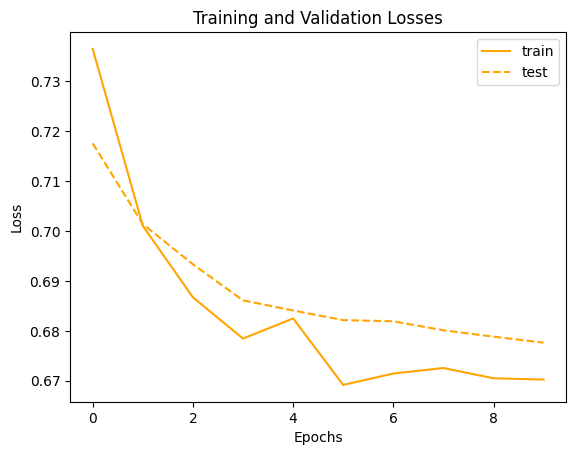

In [79]:
import matplotlib.pyplot as plt

# Define los colores para cada modelo
colors = {'Original model': 'orange'}

# Gráfica de Training losses
plt.title("Training and Validation Losses")
plt.plot(epochs, original_train_loss, label='train', color=colors['Original model'])

# Gráfica de Validation loss
plt.plot(epochs, original_val_loss, linestyle='--', label='test', color=colors['Original model'])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a0d8de10-67b4-4979-975b-dac271c8129d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>